#Stores Recommendation System

##Importing libraries

In [ ]:
# Suppressing warnings for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing essential data handling libraries
import pandas as pd
import numpy as np

# Importing visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

## Importing Dataset

In [ ]:
# Loading the dataset
import pandas as pd

# Path to the dataset
file_path = '/content/drive/MyDrive/ratings_stores.csv'

# Reading the data without headers
store_ratings = pd.read_csv(file_path, header=None)

# Assigning new column labels
store_ratings.columns = ['UserID', 'StoreID', 'Rating', 'Timestamp']

# Removing the Timestamp column as it's not needed for our analysis
store_ratings.drop(columns=['Timestamp'], inplace=True)

# Creating a backup of the DataFrame for further use
ratings_backup = store_ratings.copy()

## Exploratory Data Analysis Overview

In this section, we delve into preliminary data exploration to understand our dataset's structure and quality better. Key areas of focus include:

- **Dataset Structure**: Examining the dimensions of the data (rows and columns).
- **Data Types**: Identifying the type of data each column holds.
- **Missing Values**: Investigating the presence of any incomplete or missing data in the dataset.

Post this initial analysis, we aim to extract insightful summaries:

- **Rating Distribution Analysis**: Studying how ratings are distributed across the dataset.
- **Count of Users and Products**: Quantifying the total number of unique users and products in our dataset.
- **Top Reviewers**: Identifying users who have provided the most ratings.

This exploratory phase is crucial for guiding further data processing and analysis steps.

### Shape

In [ ]:
# Code to determine and print the dimensions of a DataFrame

# Assuming 'dataframe' is your DataFrame variable
row_count, column_count = dataframe.shape

# Displaying the number of rows and columns
print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")

No of rows =  7824482
No of columns =  3


### Datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Missing value analysis

In [ ]:
# Find number of missing values in each column
df.isna().sum()

### Summary

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

### Rating distribution

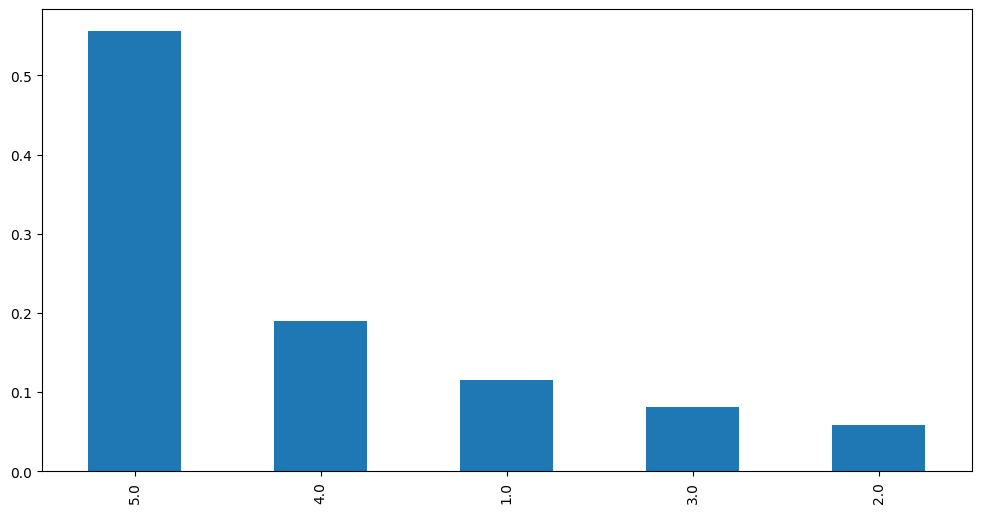

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [ ]:
# Code to print the number of unique user IDs and store IDs

# Assuming 'dataframe' is your DataFrame variable and it contains columns 'user_id' and 'store_id'
unique_users = dataframe['user_id'].nunique()
unique_stores = dataframe['store_id'].nunique()

# Displaying the number of unique users and stores
print(f"Number of Unique Users in the Data: {unique_users}")
print(f"Number of Unique Stores in the Data: {unique_stores}")

# This code snippet assumes you have a DataFrame named 'dataframe' with the required columns.

### Users with most no of rating

In [ ]:
# Code to find the top 10 users based on the number of ratings

# Assuming 'data' is your DataFrame and it contains a column named 'user_id'
# Grouping the data by 'user_id' and counting the number of ratings per user
top_raters = data.groupby('user_id').size().sort_values(ascending=False).head(10)

# Displaying the top 10 users based on the number of ratings
top_raters

## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique STORES in the final data = ', df_final['prod_id'].nunique())

- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

# Rank Based Recommendation System

In [ ]:
#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [ ]:
final_ratings_matrix.head()

Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

### Function to find Similar users and their similarity scores

In [ ]:
def find_similar_users(user_id, matrix):
    user_similarity_scores = []
    for other_user in range(matrix.shape[0]):
        # Compute the cosine similarity between the input user and every other user
        similarity = cosine_similarity([matrix.loc[user_id]], [matrix.loc[other_user]])

        # Store the user ID and similarity score
        user_similarity_scores.append((other_user, similarity[0][0]))

    # Sort based on similarity scores in descending order
    user_similarity_scores.sort(key=lambda x: x[1], reverse=True)

    # Extracting user IDs and their corresponding similarity scores
    similar_user_ids = [pair[0] for pair in user_similarity_scores]
    scores = [pair[1] for pair in user_similarity_scores]

    # Remove the original user's ID and score
    similar_user_ids.remove(user_id)
    scores.remove(scores[0])

    return similar_user_ids, scores

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [ ]:
similar = find_similar_users(3,final_ratings_matrix)[0][0:10]
similar

In [ ]:
#Print the similarity score
find_similar_users(3,final_ratings_matrix)[1][0:10]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [ ]:
similar = find_similar_users(1521, final_ratings_matrix)[0][0:10]
similar

In [ ]:
#Print the similarity score
find_similar_users(1521,final_ratings_matrix)[1][0:10]

### Function to recommend products

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [ ]:
recommendations(3,5,final_ratings_matrix)

['B001TAAVP4', 'B0016E5X5Q', 'B0054U6CEE', 'B00006IW1X', 'B000HWVOFQ']

# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [ ]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [ ]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [ ]:
U.shape

(1540, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [ ]:
def get_recommendations(user_id, number_of_items, user_item_matrix):
    # Get similar users from the previously defined function
    similar_users_list = find_similar_users(user_id, user_item_matrix)[0]

    # Retrieve items that the input user has already interacted with
    user_items = set(user_item_matrix.columns[user_item_matrix.loc[user_id] > 0])
    recommended_items = []

    # Keeping track of items that have already been considered
    considered_items = user_items.copy()

    for user in similar_users_list:
        if len(recommended_items) < number_of_items:
            # Identify items rated by similar users but not by the input user
            items_from_similar = set(user_item_matrix.columns[user_item_matrix.loc[user] > 0])
            new_recommendations = items_from_similar - considered_items
            recommended_items.extend(new_recommendations)

            # Update the considered items
            considered_items.update(items_from_similar)
        else:
            break

    # Return the top 'number_of_items' recommendations
    return recommended_items[:number_of_items]

### Recommending top 5 products to user id 121

In [ ]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)

## Evaluating the model

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

In [ ]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

In [ ]:
preds_df.head()

In [ ]:
avg_preds=preds_df.mean()
avg_preds.head()

In [ ]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

In [ ]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')